# Эксперименты в задаче сегментации построек Майя по спутниковым снимкам

Виктор Шляхин

# Эксперимент 4. Расширение входящего слоя модели до 6 каналов

Первый слой backbone DeepLabV3 был расширен на 3 входящих канала. Веса добавленных каналов были инициализированы из равномерного распределения в соответствии со стандартными рекомендациями по такой инициализации. На вход модели подавались шестиканальные картинки, содержащие 3 rgb канала, а также 97 и 103 каналы с sentinel1 (средние по VV и VH диапазонам за 2017-2020 годы) и канал 1 со спутника sentinel2. 

Результат (среднее IoU):0.8332

Веса моделей в приложенном файле maya_3+3.pth

Wandb-отчет доступен по ссылке: 

# Данные

Данные предварительно загружены в Каггл-среду. Также в силу невозможности в этой среде подключать пользовательские модули, предложенные модули вставлены в общий ноутбук с соответствующими исправлениями.

In [ ]:
#!pip install wandb --upgrade

In [ ]:
%matplotlib inline

#from google.colab import drive
#drive.mount('/content/drive')
%cd /kaggle/input/maya-ch/

# Эта библиотека нужна для чтения спутниковых снимков -- у них особый формат файла.
!easy_install GDAL

# !unzip ./DiscoverMayaChallenge_data.zip -d ./data

/kaggle/input/maya-ch
Searching for GDAL
Best match: GDAL 3.2.1
Adding GDAL 3.2.1 to easy-install.pth file
Installing gdal_sieve.py script to /opt/conda/bin
Installing gdal_proximity.py script to /opt/conda/bin
Installing gcps2wld.py script to /opt/conda/bin
Installing gdal2xyz.py script to /opt/conda/bin
Installing gdal2tiles.py script to /opt/conda/bin
Installing gdal_calc.py script to /opt/conda/bin
Installing gdalcompare.py script to /opt/conda/bin
Installing pct2rgb.py script to /opt/conda/bin
Installing esri2wkt.py script to /opt/conda/bin
Installing gdal_edit.py script to /opt/conda/bin
Installing gdal_pansharpen.py script to /opt/conda/bin
Installing gdal_merge.py script to /opt/conda/bin
Installing gdalident.py script to /opt/conda/bin
Installing gdalimport.py script to /opt/conda/bin
Installing gdalmove.py script to /opt/conda/bin
Installing epsg_tr.py script to /opt/conda/bin
Installing rgb2pct.py script to /opt/conda/bin
Installing gdal_fillnodata.py script to /opt/conda/bi

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

from osgeo import gdal, gdal_array

from pathlib import Path
from copy import copy
from torch.utils.data import Dataset, random_split
import torch
from torch import nn
from torchvision import transforms as T
from torch.nn import functional as F

import torchvision.transforms.functional as transforms_F

import pickle

from pathlib import Path

from torchvision import models
from torch.utils.data import DataLoader
from torch import optim

import wandb

from tqdm.notebook import tqdm, trange

from scipy import sparse
from PIL import Image, ImageOps
import os

mask_train_path = Path('./train_masks')
lidar_train_path = Path('./lidar_train')
sent1_train_path = Path('./Sentinel1_train')

In [ ]:
import fastai
import PIL


default_sentinel1_bands =  [
        97, #mean vv
        99, #std vv
        103, #mean vh
        105 #std vh
    ]
default_sentinel2_bands = [0] 



def gather_tile_ids(path):
    ids = []

    files = os.listdir(path)
    for name in files:
        if 'tile_' not in name:
            continue
        ids.append(int(name.split('_')[1]))
    return set(ids)


class ChactunDataset(Dataset):
    classes = ['aguada', 'building', 'platform']

    def __init__(self, 
                root_folder, 
                is_train=True, 
                transform=None,
                sentinel1_bands=None,
                sentinel2_bands=None):
        super().__init__()
        if sentinel1_bands is None:
            sentinel1_bands = default_sentinel1_bands
        if sentinel2_bands is None:
            sentinel2_bands = default_sentinel2_bands
        self.sentinel1_bands = sentinel1_bands
        self.sentinel2_bands = sentinel2_bands

        self.root = Path(root_folder)
        self.type = 'train' if is_train else 'test'
        self.transform = transform
        self.num_bands = 3 + len(sentinel1_bands + sentinel2_bands)

        if is_train:
            self.masks_path = self.root / f'{self.type}_masks'
        self.lidar_path = self.root / f'lidar_{self.type}'
        self.sentinel1_path = self.root / f'Sentinel1_{self.type}'
        self.sentinel2_path = self.root / f'Sentinel2_{self.type}'

        self.ids = list(self.gather_complete_tile_ids())

    def gather_complete_tile_ids(self):
        if self.type == 'train':
            masks_ids = gather_tile_ids(self.masks_path)
        lidar_ids = gather_tile_ids(self.lidar_path)
        sentinel1_ids = gather_tile_ids(self.sentinel1_path)
        sentinel2_ids = gather_tile_ids(self.sentinel2_path)

        complete_ids = lidar_ids & sentinel1_ids & sentinel2_ids
        all_ids = lidar_ids | sentinel1_ids | sentinel2_ids
        if self.type == 'train':
            complete_ids &= masks_ids
            all_ids |= masks_ids

        if len(lidar_ids) < len(all_ids):
            print(f'Lidar images are missing ids: [{all_ids - lidar_ids}]')
        if len(sentinel1_ids) < len(all_ids):
            print(f'Sentinel1 images are missing ids: [{all_ids - sentinel1_ids}]')
        if len(sentinel2_ids) < len(all_ids):
            print(f'Sentinel2 images are missing ids: [{all_ids - sentinel2_ids}]')
        
        return complete_ids

    def load_lidar(self, id):
        pil_img = Image.open(self.lidar_path / f'tile_{id}_lidar.tif')
        return T.functional.to_tensor(pil_img)

    def load_sentinel1(self, id):
        if len(self.sentinel1_bands) == 0:
            return None
            
        img = gdal_array.LoadFile(str(self.sentinel1_path / f'tile_{id}_S1.tiff'))
        return torch.from_numpy(img)[self.sentinel1_bands]

    def load_sentinel2(self, id):
        if len(self.sentinel2_bands) == 0:
            return None

        img = gdal_array.LoadFile(str(self.sentinel2_path / f'tile_{id}_S2.tiff'))
        return torch.from_numpy(img)[self.sentinel2_bands]

    def load_masks(self, id):
        if self.type == 'test':
            raise NotImplementedError('This dataset is meant for testing and doesn\'t have masks.')
        pil_masks = [np.array(Image.open(self.masks_path / f'tile_{id}_mask_{mask_class}.tif'))
                        for mask_class in self.classes]
        tensor_masks = torch.from_numpy(np.stack(pil_masks)).type(torch.float32) / 255
        # invert masks. Originally 1 = not present, 0 = present
        tensor_masks = 1 - tensor_masks
        return tensor_masks

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        id = self.ids[i]

        x = {'lidar': self.load_lidar(id), 
             'sentinel1': self.load_sentinel1(id), 
             'sentinel2': self.load_sentinel2(id)}
        if self.type == 'train':
            y = self.load_masks(id)
        else:
            y = None

        if self.transform:
            x, y = self.transform(x, y)
        return x, y


class UpsampleSentinelToLidar(object):
    def __call__(self, images, target=None):
        lidar_size = images['lidar'].shape[1:]

        if images['sentinel1'] is not None:
            images['sentinel1'] = T.functional.resize(images['sentinel1'], lidar_size,
                                                  interpolation=PIL.Image.BILINEAR)
        if images['sentinel2'] is not None:
            images['sentinel2'] = T.functional.resize(images['sentinel2'], lidar_size,
                                                  interpolation=PIL.Image.BILINEAR)
        
        merged_image = torch.cat([img_channels for img_channels in images.values() 
                                    if img_channels is not None], dim=0)
        return merged_image, target

In [ ]:

import random
from torchvision.transforms import functional as TF


def pad_if_smaller(img, size, fill=0):
    min_size = min(img.shape[1:])
    if min_size < size:
        
        och, ow, oh = img.size()
        
        padh = size - oh if oh < size else 0
        padw = size - ow if ow < size else 0
        img = TF.pad(img, (0, 0, padw, padh), fill=fill)
    return img


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomResize(object):
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        size = random.randint(self.min_size, self.max_size)
        image = TF.resize(image, size)
        if target is not None:
            target = TF.resize(target, size, interpolation=Image.NEAREST)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = TF.hflip(image)
            if target is not None:
                target = TF.hflip(target)
        return image, target


class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = pad_if_smaller(image, self.size)
        target = pad_if_smaller(target, self.size, fill=1)
        crop_params = T.RandomCrop.get_params(image, (self.size, self.size))
        image = TF.crop(image, *crop_params)
        if target is not None:
            target = TF.crop(target, *crop_params)
        return image, target


class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = TF.center_crop(image, self.size)
        if target is not None:
            target = TF.center_crop(target, self.size)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = TF.to_tensor(image)
        if target is not None:
            target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = TF.normalize(image, mean=self.mean, std=self.std)
        return image, target

In [ ]:
# Определим для удобства словарь с параметрами эксперимента, пока стандартными для бейзлайна
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

config = DotDict()
# Файл./dataset_stats.pickle я не нашел, поэтому задал некие параметры, тем более, их далее не использую.
config.mean, config.std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# Задаем интервал ресайза для аугментации. Пока он совпадает с необходимым размером картинки для бейзлайна.
config.resize_min = 250
config.resize_max = 250
# Здесь мы задаем конечный размер картинки, которую выдает нам датасет и которая подается в модель.
config.crop_size = 250
config.pretrained = True
config.num_classes = len(ChactunDataset.classes)
config.batch_size = 2
config.epochs = 5
config.lr = 1e-3
config.momentum = 0.9
config.sentinel1_bands = []
config.sentinel2_bands = []

In [ ]:
def get_transofrms(h_flip_prob, resize_min, resize_max, crop_size, mean, std):
    train_transform = Compose([        
        UpsampleSentinelToLidar(),
        RandomResize(resize_min, resize_max),
        RandomCrop(crop_size)
    ])
    test_transform = Compose([
        UpsampleSentinelToLidar()
    ])

    return train_transform, test_transform

def get_dataset(config, root='./', val_size=0.25):
    train_transform, test_transform = get_transofrms(
        config.h_flip_prob,
        config.resize_min,
        config.resize_max,
        config.crop_size,
        config.mean,
        config.std
    )

    # У нас есть два датасета, один с ответами, а другой без.
    # Первый датасет мы поделим на train часть и валидационную часть.
    ds = ChactunDataset(root, is_train=True, transform=train_transform,
                        sentinel1_bands=config.sentinel1_bands,
                        sentinel2_bands=config.sentinel2_bands)
    train_ds, val_ds = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])

    test_ds = ChactunDataset(root, is_train=False, transform=test_transform,
                             sentinel1_bands=config.sentinel1_bands,
                             sentinel2_bands=config.sentinel2_bands)

    return train_ds, val_ds, test_ds

In [ ]:
# Определим функции дискретизации масок и метрики IoU
def discretize_segmentation_maps(probs, thresh):
    if thresh is None:
        thresh = [0.5, 0.5, 0.5]
    if isinstance(thresh, int):
        thresh = [thresh] * 3
    thresh = torch.from_numpy(np.array(thresh)).to(probs.device)
    return probs > thresh[:, None, None]

def get_ious(y_pred, y_true, thresh=None, eps=1e-7):
    y_pred = discretize_segmentation_maps(y_pred, thresh).float()
    y_true = y_true.float()
    with torch.no_grad():
        intersection = torch.sum(y_true * y_pred, dim=[2, 3])
        union = torch.sum(y_true, dim=[2, 3]) + torch.sum(y_pred, dim=[2, 3]) - intersection
        ious = ((intersection + eps) / (union + eps)).mean(dim=0)
    return ious

# Обучение

In [ ]:
# Определим интервал ресайза.
config.resize_min = 125
config.resize_max = 500

# Добавим нужные каналы с sentinel, получим 6-канальные входные изображения.
config.sentinel1_bands = [97, 103]
config.sentinel2_bands = [0]

# Загрузим данные, определим даталоадеры
train_ds, val_ds, test_ds = get_dataset(config)
train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=config.batch_size, drop_last=True)

In [ ]:
class DeepLabV3_2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True
        )
        
        self.pre_weight = self.model.backbone.conv1.weight.data
        self.model.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        k = np.sqrt(1. / 6 * 7 * 7)
        self.add_weight = torch.FloatTensor(64, 3, 7, 7).uniform_(-k, k)
        self.model.backbone.conv1.weight.data = torch.cat((self.pre_weight, self.add_weight), dim=1)
        #self.model.backbone.conv1.weight.data = torch.cat((self.pre_weight, self.pre_weight), dim=1)

        self.model.classifier[4] = nn.Conv2d(256, self.config.num_classes, 1)

    def forward(self, X):
        return torch.sigmoid(self.model(X)['out'])

model2 = DeepLabV3_2(config)

In [ ]:
config.epochs = 5
# Стандартное определение лосса, оптимизатора и lr scheduler.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
crit = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=config.lr)
sched = optim.lr_scheduler.OneCycleLR(optimizer, config.lr, 
                                      epochs=config.epochs, 
                                      steps_per_epoch=len(train_dl))
model2 = model2.to(device)

In [ ]:

wandb.login()
wandb.init(config=config)
wandb.watch(model2, log_freq=100)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp

wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory


wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory


wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory


iou_aguada,0.96949
iou_building,0.74674
iou_platform,0.71033
avg_iou,0.80885
loss,0.00082
_runtime,3132
_timestamp,1624792008
_step,3314
val_loss,0.01045


iou_aguada,▁▆▃█▆████████████████████▆████▃████▃█▃▃█
iou_building,▂▃▃█▆▇▄▅▂▆▇▆▃▄▄▁▄█▄▅▄█▆█▅▇█▅▄█▄▃▆██▇▅▃▅▇
iou_platform,█▃▁█▆▇▄▆▆▅▇▆▅▄▄█▁██▄▁█▄█▄▇█▄▂▄▄▂▆██▇▄▄▅▆
avg_iou,▃▃▁█▅▇▅▅▄▅▇▆▅▅▅▅▃█▆▅▃█▅█▄▆█▅▃▆▃▃▆██▆▅▂▃▇
loss,█▆▄▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▅█▁▃▂


wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory


wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writ

wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory


In [ ]:
from tqdm.notebook import tqdm, trange

for i in trange(config.epochs):
    model2.train()
    for X, y in tqdm(train_dl):
        X = X.to(device)
 
        y = y.to(device)
        
        optimizer.zero_grad()
        pred = model2(X)
        loss = crit(pred, y)
        loss.backward()
        optimizer.step()
        sched.step()
        
        #LOG metrics to wandb
        ious = get_ious(pred, y, config.prediction_thresh).cpu()

        metrics = {'iou_' + class_name: iou_score.item()
                for class_name, iou_score in zip(ChactunDataset.classes, ious)}
        metrics['avg_iou'] = ious.mean()
        metrics['loss'] = loss.item()
        metrics['lr'] = sched.get_last_lr()
        wandb.log(metrics)

    model2.eval()
    losses = []
    ious = []
    for X, y in val_dl:
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = model2(X)
            losses.append(crit(pred, y).item())
            iou = get_ious(pred, y, config.prediction_thresh)
            ious.append(iou)

    metrics = {'iou_' + class_name: iou_score
                for class_name, iou_score in zip(ChactunDataset.classes, torch.mean(torch.stack(ious), dim=0))}
    metrics['avg_iou'] = torch.mean(torch.stack(ious), dim=0).mean() 

    metrics['val_loss'] = np.mean(losses)
    wandb.log(metrics)
    print(metrics)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /kaggle/input/maya-ch/wandb/ wasn't writable, using system temp directory


{'iou_aguada': tensor(0.9406, device='cuda:0'), 'iou_building': tensor(0.6216, device='cuda:0'), 'iou_platform': tensor(0.6730, device='cuda:0'), 'avg_iou': tensor(0.7450, device='cuda:0'), 'val_loss': 0.016025166791884905}


  0%|          | 0/662 [00:00<?, ?it/s]

{'iou_aguada': tensor(0.9652, device='cuda:0'), 'iou_building': tensor(0.7372, device='cuda:0'), 'iou_platform': tensor(0.7085, device='cuda:0'), 'avg_iou': tensor(0.8037, device='cuda:0'), 'val_loss': 0.010414126065734308}


  0%|          | 0/662 [00:00<?, ?it/s]

{'iou_aguada': tensor(0.7681, device='cuda:0'), 'iou_building': tensor(0.5428, device='cuda:0'), 'iou_platform': tensor(0.4987, device='cuda:0'), 'avg_iou': tensor(0.6032, device='cuda:0'), 'val_loss': 0.10992736057424653}


  0%|          | 0/662 [00:00<?, ?it/s]

{'iou_aguada': tensor(0.9598, device='cuda:0'), 'iou_building': tensor(0.7484, device='cuda:0'), 'iou_platform': tensor(0.7111, device='cuda:0'), 'avg_iou': tensor(0.8064, device='cuda:0'), 'val_loss': 0.009158266663805328}


  0%|          | 0/662 [00:00<?, ?it/s]

{'iou_aguada': tensor(0.9672, device='cuda:0'), 'iou_building': tensor(0.7873, device='cuda:0'), 'iou_platform': tensor(0.7450, device='cuda:0'), 'avg_iou': tensor(0.8332, device='cuda:0'), 'val_loss': 0.00869134526485802}


In [ ]:
torch.save(model2.state_dict(), "/kaggle/working/maya_3+3.pth")
print(metrics)

{'iou_aguada': tensor(0.9672, device='cuda:0'), 'iou_building': tensor(0.7873, device='cuda:0'), 'iou_platform': tensor(0.7450, device='cuda:0'), 'avg_iou': tensor(0.8332, device='cuda:0'), 'val_loss': 0.00869134526485802}


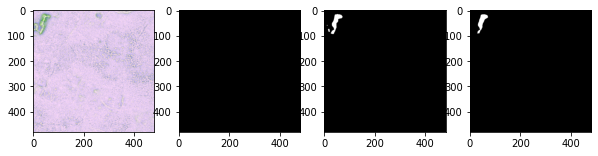

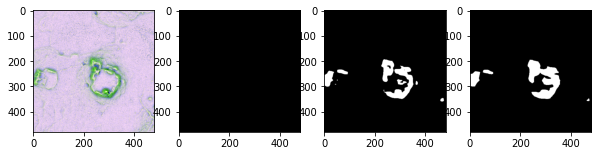

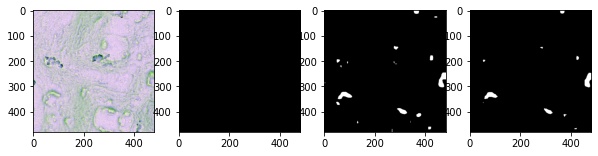

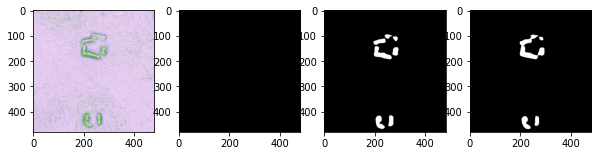

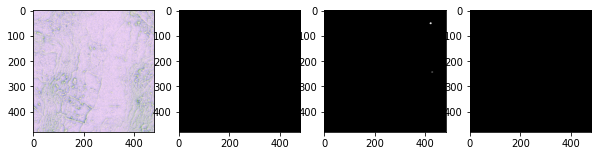

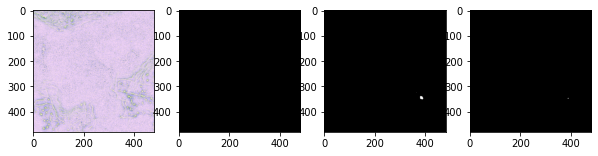

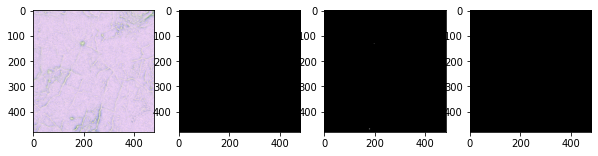

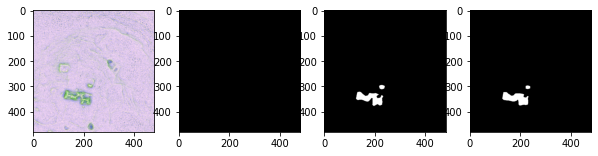

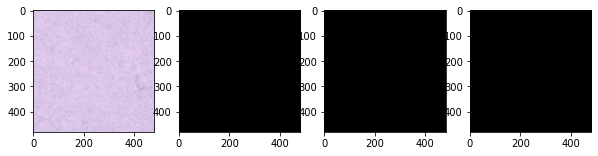

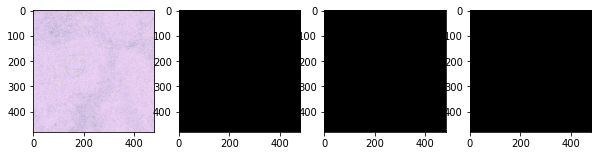

In [ ]:
# Визуализация с теста
val_iter= iter(test_ds)

for i in range(10):
    X, y = next(val_iter)
    
    with torch.no_grad():
            pred = model2(X.unsqueeze(0).to(device))
            masks = discretize_segmentation_maps(pred, config.thresh).squeeze(0)
            masks = masks.cpu().numpy()
            masks = 255 - (masks * 255).astype(np.byte)
            plt.subplots(figsize=(10,4))
            plt.subplot(1, 4, 1)
            plt.imshow(X[:3, :, :].cpu().numpy().transpose(1, 2, 0))
            for i in range(3):
                plt.subplot(1, 4, i + 2)
                plt.imshow(masks[i], cmap='gray')
            plt.show()